<a href="https://colab.research.google.com/github/Olagrace837/Project-2/blob/main/Exercise_Volcano_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


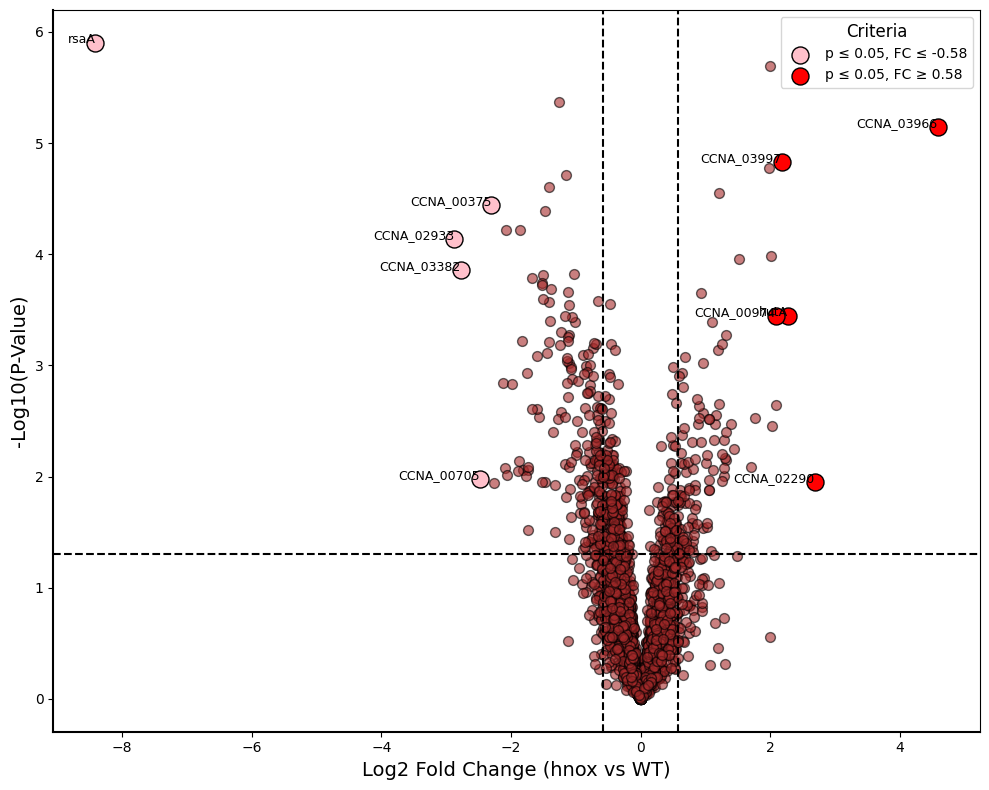

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Olagrace837/Project-2/refs/heads/main/Exercise%2034%20(log).csv'
df = pd.read_csv(url)

# Convert relevant columns to numeric, coercing errors to NaN
numeric_cols = ['Control_1', 'Control_2', 'Control_3', 'KO_1', 'KO_2', 'KO_3']
for col in numeric_cols:
    # Check if the column exists before attempting conversion
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['Control_1', 'Control_2', 'Control_3']].mean(axis=1)
df['hnox_Mean'] = df[['KO_1', 'KO_2', 'KO_3']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['Control_1', 'Control_2', 'Control_3']].values,
    df[['KO_1', 'KO_2', 'KO_3']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# --- MODIFIED: Filter top 5 significant genes from both sides more explicitly ---
# Define significance and fold change thresholds for determining "top" genes
p_value_threshold = 0.05 # For statistical significance
log2_fc_threshold_abs = 0.58 # For biological significance (absolute value)

# Filter for genes that are statistically significant
significant_df = df[df['P_Value'] < p_value_threshold]

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC above threshold)
top_5_up = significant_df[significant_df['Log2_FC'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC below threshold)
top_5_down = significant_df[significant_df['Log2_FC'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC')

# Combine these to form the top_genes for labeling on the plot
top_genes = pd.concat([top_5_up, top_5_down]).drop_duplicates(subset=['Gene Name'])
# --- END MODIFIED SECTION ---

# Separate significant genes for coloring (these now filter from the new 'top_genes')
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]




# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown') # Changed color to brown

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='pink', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58') # Changed color to pink
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58') # Changed color to red

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene Name'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [2]:
print("\nTop 5 Upregulated Genes:")
display(top_genes[top_genes['Log2_FC'] > 0].nlargest(5, 'Log2_FC')[['Gene Name', 'Log2_FC']])

print("\nTop 5 Downregulated Genes:")
display(top_genes[top_genes['Log2_FC'] < 0].nsmallest(5, 'Log2_FC')[['Gene Name', 'Log2_FC']])


Top 5 Upregulated Genes:


,Gene Name,Log2_FC
2364,CCNA_03966,4.586581
2475,CCNA_02290,2.686651
103,hutA,2.273965
2152,CCNA_03997,2.178302
8,CCNA_00974,2.088362



Top 5 Downregulated Genes:


,Gene Name,Log2_FC
1621,rsaA,-8.411241
252,CCNA_02933,-2.876300
222,CCNA_03382,-2.770354
2635,CCNA_00705,-2.483461
2435,CCNA_00375,-2.301410
